<a href="https://colab.research.google.com/github/bigbulgogiburger/Creon-Datareader-master/blob/master/LSTM%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%B5%EC%9E%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import set
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
#Keras를 활용한 lstm 모델 생성
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import os
import sqlite3

In [ ]:
###########매우중요. 한글폰트를 코랩에 삽입하는 이 코드는 가장먼저 실행하신 후 위쪽에 런타임-'런타임 다시 시작'을 누르시고, 이 코드 재실행바랍니다아아..
########## 한글 폰트가 설정이 안되어 있지만, 설치하시고 리스타트하는 개념인거 같아용


!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)
fm._rebuild()
 
# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'
 
# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

In [ ]:
# 데이터 단위를 20일로 하여, 20일을 저장 후 데이터 단위를 20일로 하여, 20일을 저장 후 해당 마지말 날에 종가를 예측.
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:

# LSTM으로 딥러닝... 하는...함수....
# 변수나 옵티마이저나 기타 등등 하이퍼 파라미터는 마음대로 저장하세요
def image_collector(datachart):
  for stockcode,comname in datachart:
    data = pd.read_csv(stockcode+".csv")
    data['day']=pd.to_datetime(data['day'],format='%Y%m%d')

    #datetime으로 변환하기.
    data['year']=data['day'].dt.year
    data['month']=data['day'].dt.month
    data['date']=data['day'].dt.day

    scaler = MinMaxScaler()

#####스케일링할 컬럼을 [시가 , 고가, 저가, 종가, 거래량]으로 작성해주세요######
    scale_cols =['cur_pr',	'high_pr',	'low_pr',	'clo_pr',	'pr_diff',	'acc_vol']

    data_scaled = scaler.fit_transform(data[scale_cols]) #=>ndarray생성

    data_scaled=pd.DataFrame(data_scaled)#DataFrame 생성

    data_scaled.columns = scale_cols

    window_size=20
    TEST_SIZE = 200

    # 트레인을 200일 전까지 테스트를 마지막 200개로 나눴다.
    train = data_scaled[:-TEST_SIZE]
    test  = data_scaled[-TEST_SIZE:]
######feature과 label로 나누는 과정입니다. feature에는[시가,고가,저가,거래량이 들어갑니다.]
    feature_cols = \
    ['cur_pr',	'high_pr',	'low_pr','acc_vol']
###### label에는 종가가 들어갑니다.
    label_cols=['clo_pr']

    train_feature = train[feature_cols] # 독립변수 설정
    train_label = train[label_cols] # 종속변수 설정

    #train dataset
    train_feature, train_label = make_dataset(train_feature, train_label)#데이터 전처리하기.
    x_train,x_valid,y_train,y_valid = train_test_split(train_feature,train_label, test_size=0.2)# train data를 train,valid로 분할

    # test dataset feature/label 분리
    test_feature = test[feature_cols]
    test_label = test[label_cols]

    # train dataset 만들기
    test_feature, test_label = make_dataset(test_feature, test_label, 20)

    #모델만들기.
    #16개의 신경망을 가진 LSTM. (None,20,4)의 인풋을 가지며, 활성화함수는 relu를쓰고, 역전파를 안한다.
    model = Sequential()
    model.add(LSTM(16,
                input_shape =(train_feature.shape[1],train_feature.shape[2]),
                activation='relu',
                return_sequences =False))

    #덴스 1층
    model.add(Dense(1))

    # 모니터링(무엇을 기준으로 patience를 볼 것인가.????)은 오차제곱평균을 기반으로하며 최적화는 아담으로 한다. 
    model.compile(loss='mean_squared_error', optimizer='adam')

    #조기 종료의 기준은 val_loss의 감소 정도이며 5번 정도 감소가 되는 폭이 적거나 같다면 조기종료 ==> 3번으로 바꿈
    early_stop = EarlyStopping(monitor='val_loss', patience=3)
    filename = os.path.join('./','tmp_checkpoint.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1,save_best_only=True,mode='auto')

    history = model.fit(x_train,y_train,
                    epochs= 200,
                    batch_size = 16,
                    validation_data=(x_valid,y_valid),
                    callbacks=[early_stop,checkpoint])

    #weight 로딩 return 따로 안함. 모델의 가중치를 로드한다.
    model.load_weights(filename)

    #예측하기 - 리턴 없음. 테스트용 로딩예측하기 - 리턴 없음. 테스트용 로딩
    pred =model.predict(test_feature)

    # 데이터 예측하기. 실제데이터와 비교해본다.
    # 테스트의 feature을 넣어주고 값을 예측한 pred는 예상치이며, test_label이 실제 값이다.
    plt.figure(figsize=(12,9))
    plt.plot(test_label, label='actual' )
    plt.plot(pred, label='prediction')
    plt.legend()
    plt.title(comname)
    plt.savefig('./image/'+comname+'.png')

In [ ]:
# 코드들을 실행하시기 전에 왼쪽 프로젝트 열어주셔서 image폴더 하나만 만들어주시길릴릴개굴개굴

#본 코드는 한번만 실행되야 합니다. 여러번 실행할시에 중복으로 만들어져요 ㅡ.ㅡ
##### 1. 코드리스트에 대한 정보만 담긴 리스트를 먼저 읽혀주세요~~
con=sqlite3.connect('stock_pyun_backup.db')
query='select * from stock_pyun_backup'
data=pd.read_sql(query,con)
data.to_csv('stock_list.csv')
con.close()

###### 2. 그 리스트를 다시 읽어들여 자신이 다운받은 정보를 코드별로 csv파일로 만들어주세요.
datas=pd.read_csv('stock_list.csv')
#####해당 컬럼명은 코드를 저장하신 컬럼명으로 바꿔주세용
datas = datas['code']
con=sqlite3.connect('stock_list_added .db')

for code in datas:
  query='select * from {}'.format(code)
  data=pd.read_sql(query,con)
  data.to_csv(code+'.csv')

In [ ]:
#코드 목록을 읽습니다.
datalists = pd.read_csv('./stock_list.csv')

In [ ]:
datalists

,Unnamed: 0,code,name
0,0,A102940,코오롱생명과학
1,1,A103230,에스앤더블류
2,2,A103840,우양
3,3,A104040,대성파인텍
4,4,A104200,NHN벅스
...,...,...,...
656,656,A950170,JTC
657,657,A950180,SNK
658,658,A950190,미투젠
659,659,A950200,소마젠(Reg.S)


In [ ]:
datalists = datalists[['code','name']].to_numpy()

Epoch 1/200
137/137 [==============================] - 5s 29ms/step - loss: 0.0135 - val_loss: 2.1676e-04

Epoch 00001: val_loss improved from inf to 0.00022, saving model to ./tmp_checkpoint.h5
Epoch 2/200
137/137 [==============================] - 4s 28ms/step - loss: 2.3463e-04 - val_loss: 1.8274e-04

Epoch 00002: val_loss improved from 0.00022 to 0.00018, saving model to ./tmp_checkpoint.h5
Epoch 3/200
137/137 [==============================] - 4s 28ms/step - loss: 2.7448e-04 - val_loss: 1.5655e-04

Epoch 00003: val_loss improved from 0.00018 to 0.00016, saving model to ./tmp_checkpoint.h5
Epoch 4/200
137/137 [==============================] - 4s 28ms/step - loss: 2.5071e-04 - val_loss: 1.5153e-04

Epoch 00004: val_loss improved from 0.00016 to 0.00015, saving model to ./tmp_checkpoint.h5
Epoch 5/200
137/137 [==============================] - 4s 27ms/step - loss: 1.7981e-04 - val_loss: 1.4350e-04

Epoch 00005: val_loss improved from 0.00015 to 0.00014, saving model to ./tmp_checkpo

KeyboardInterrupt: ignored

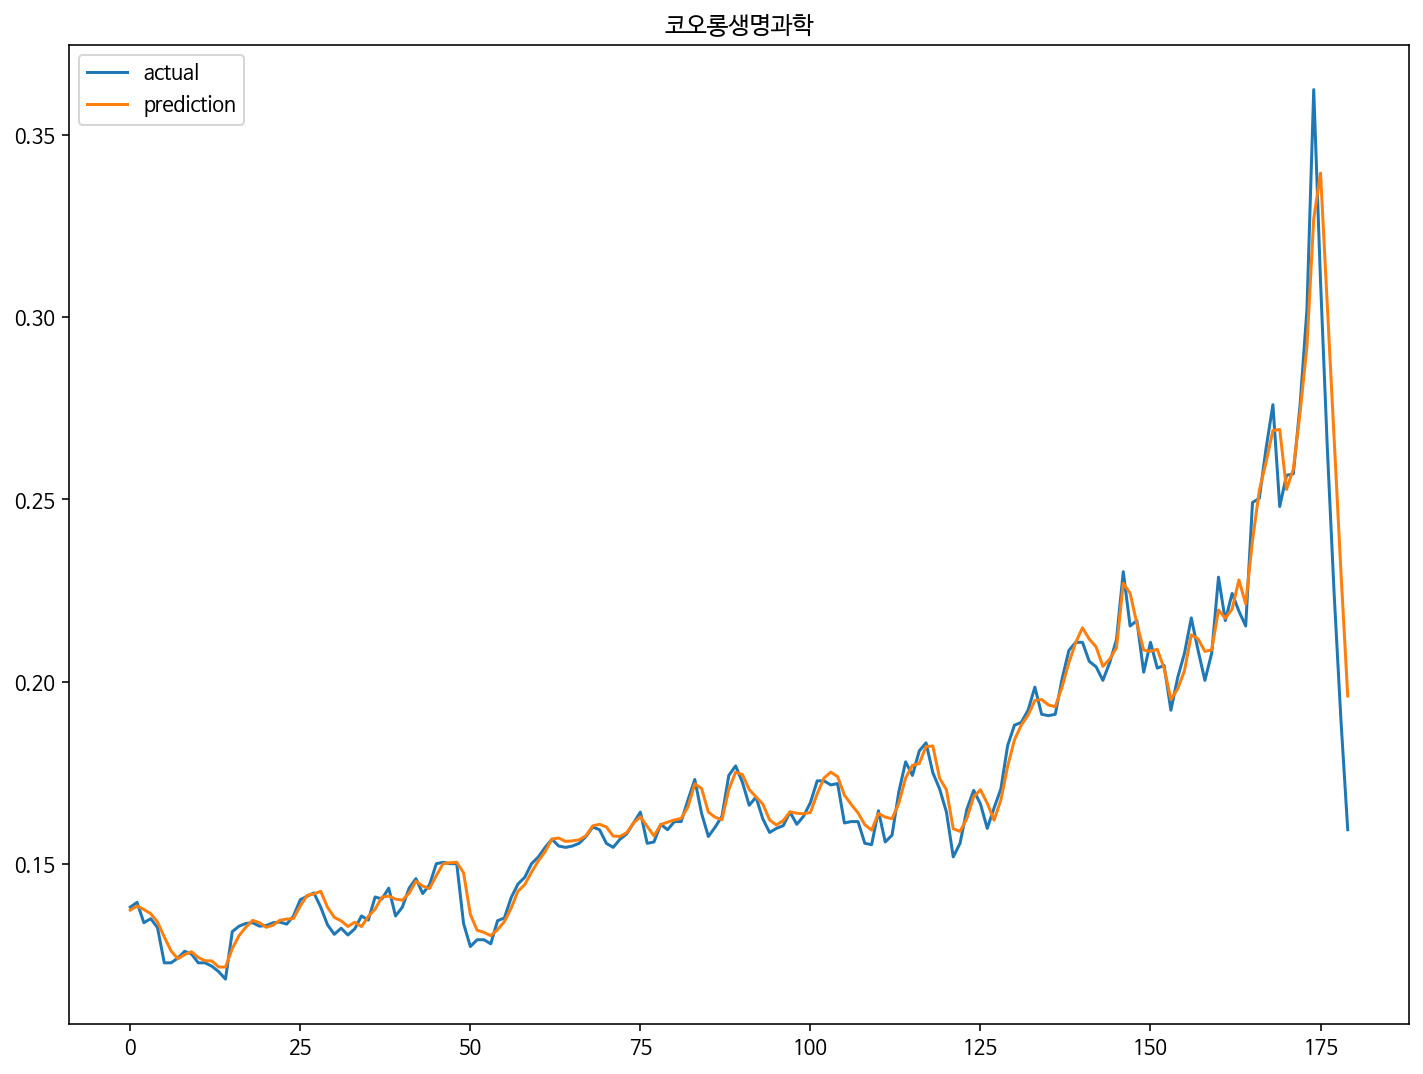

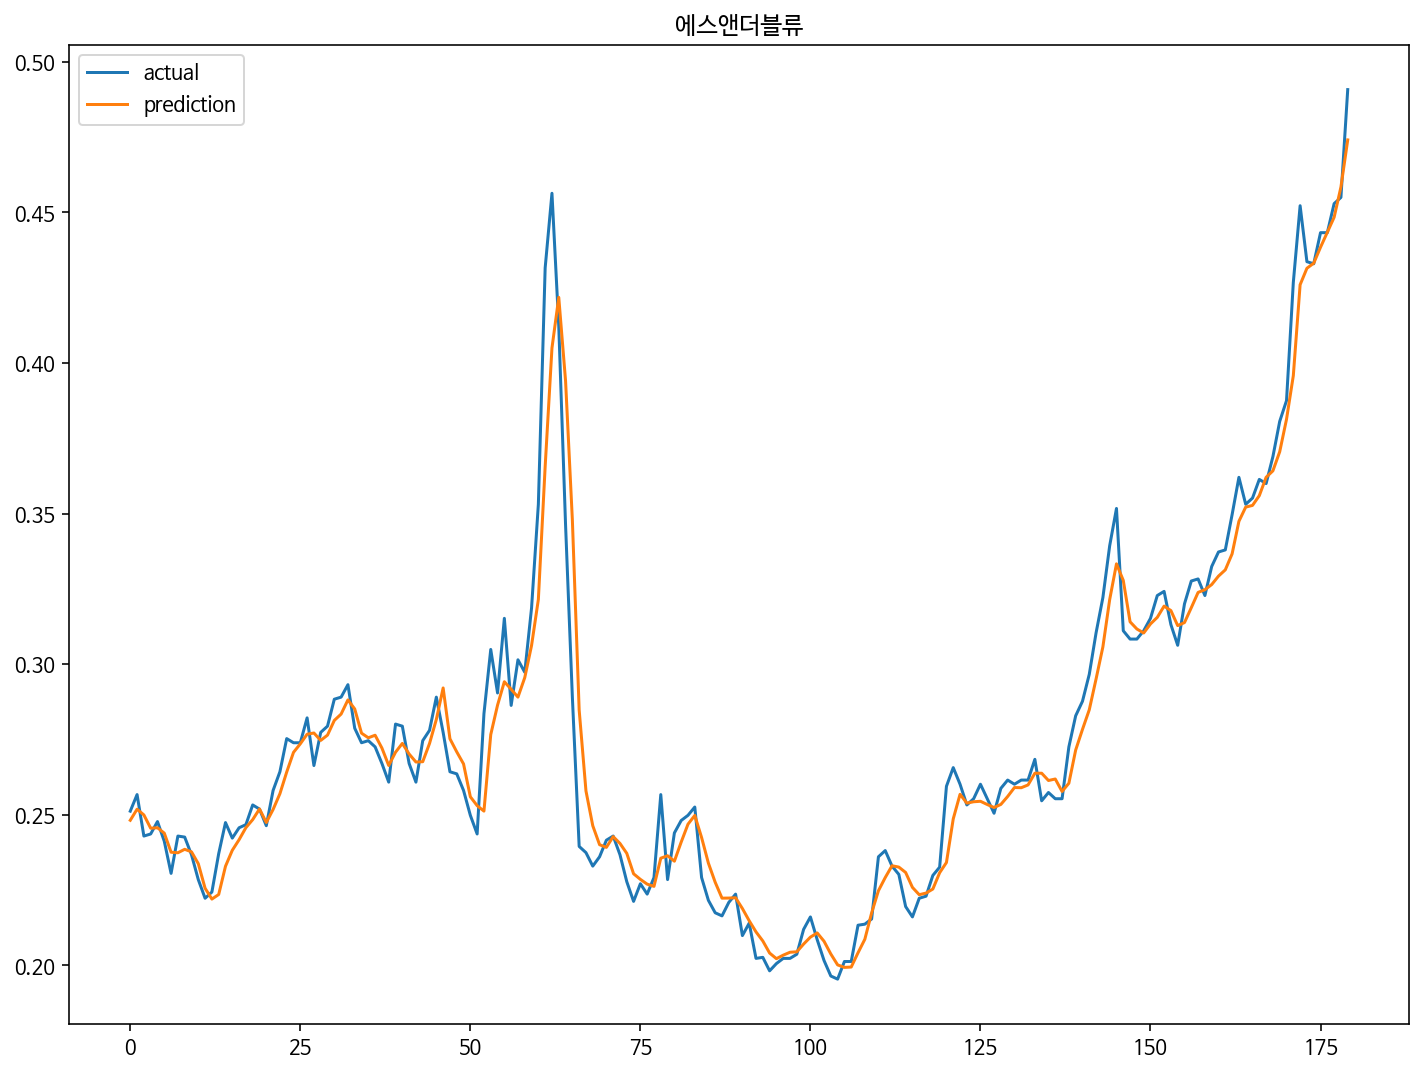

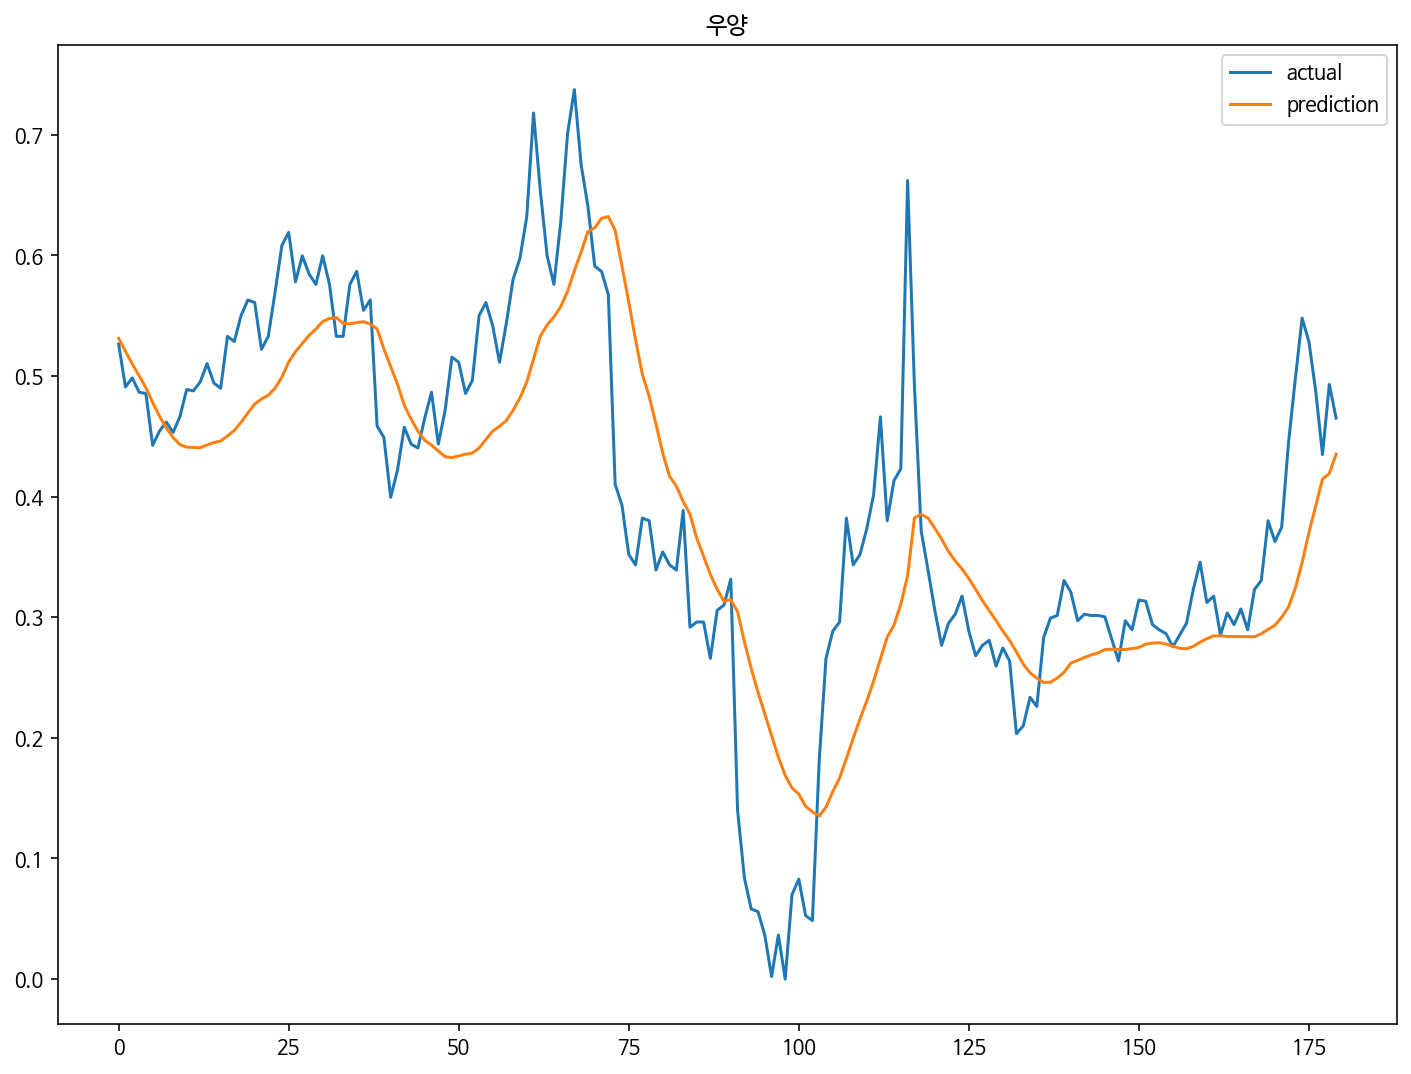

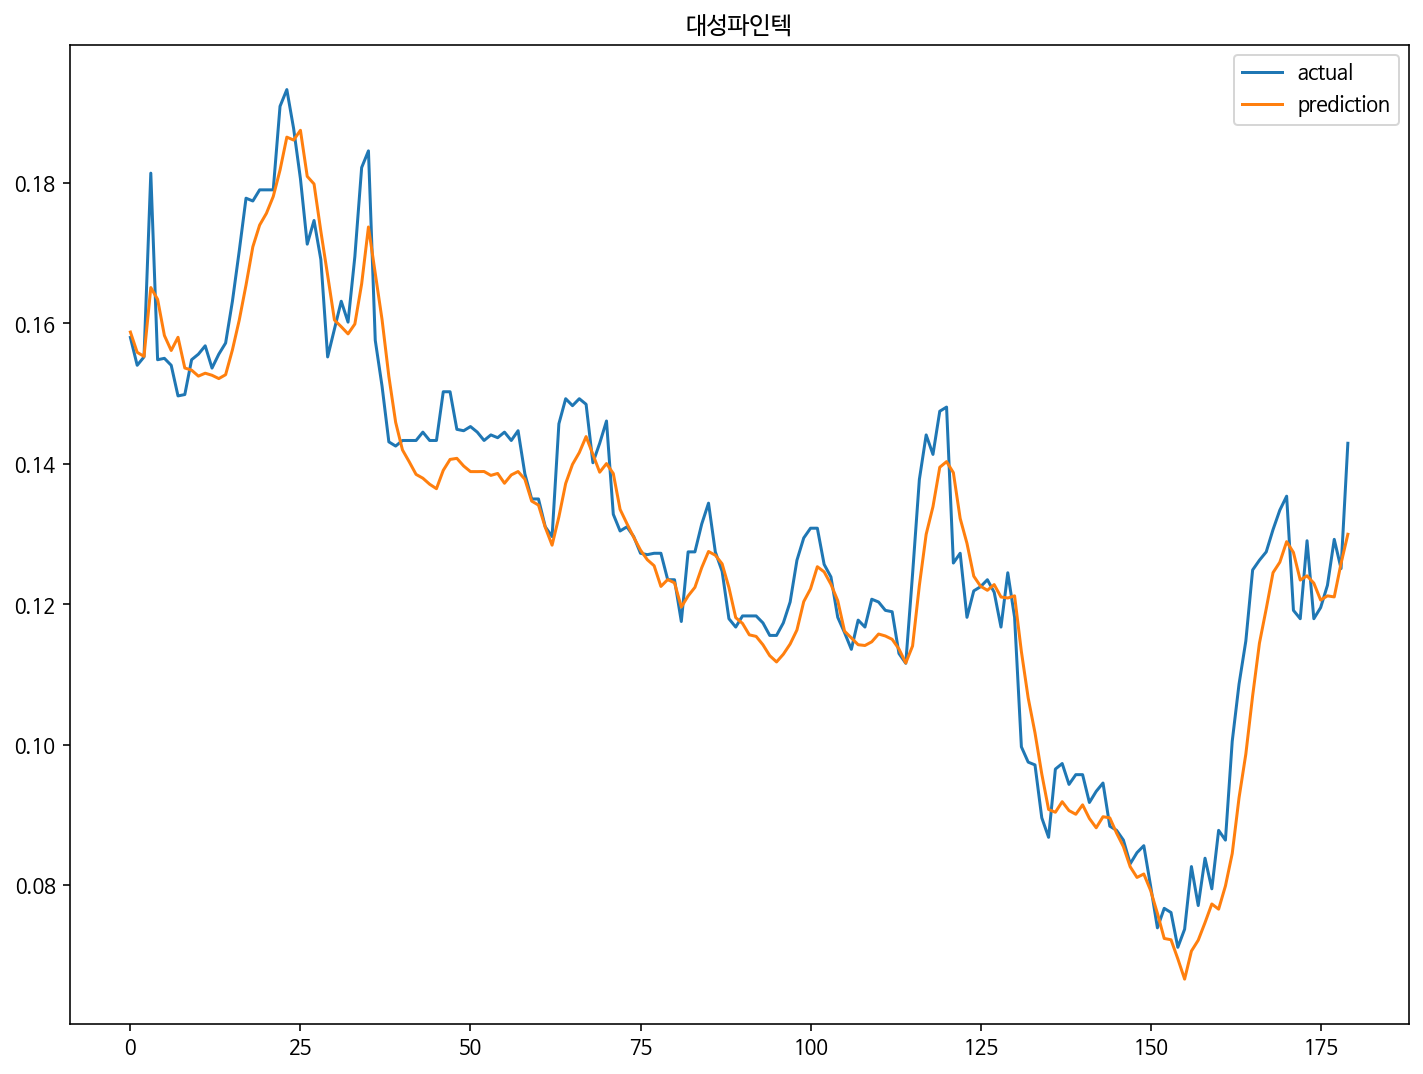

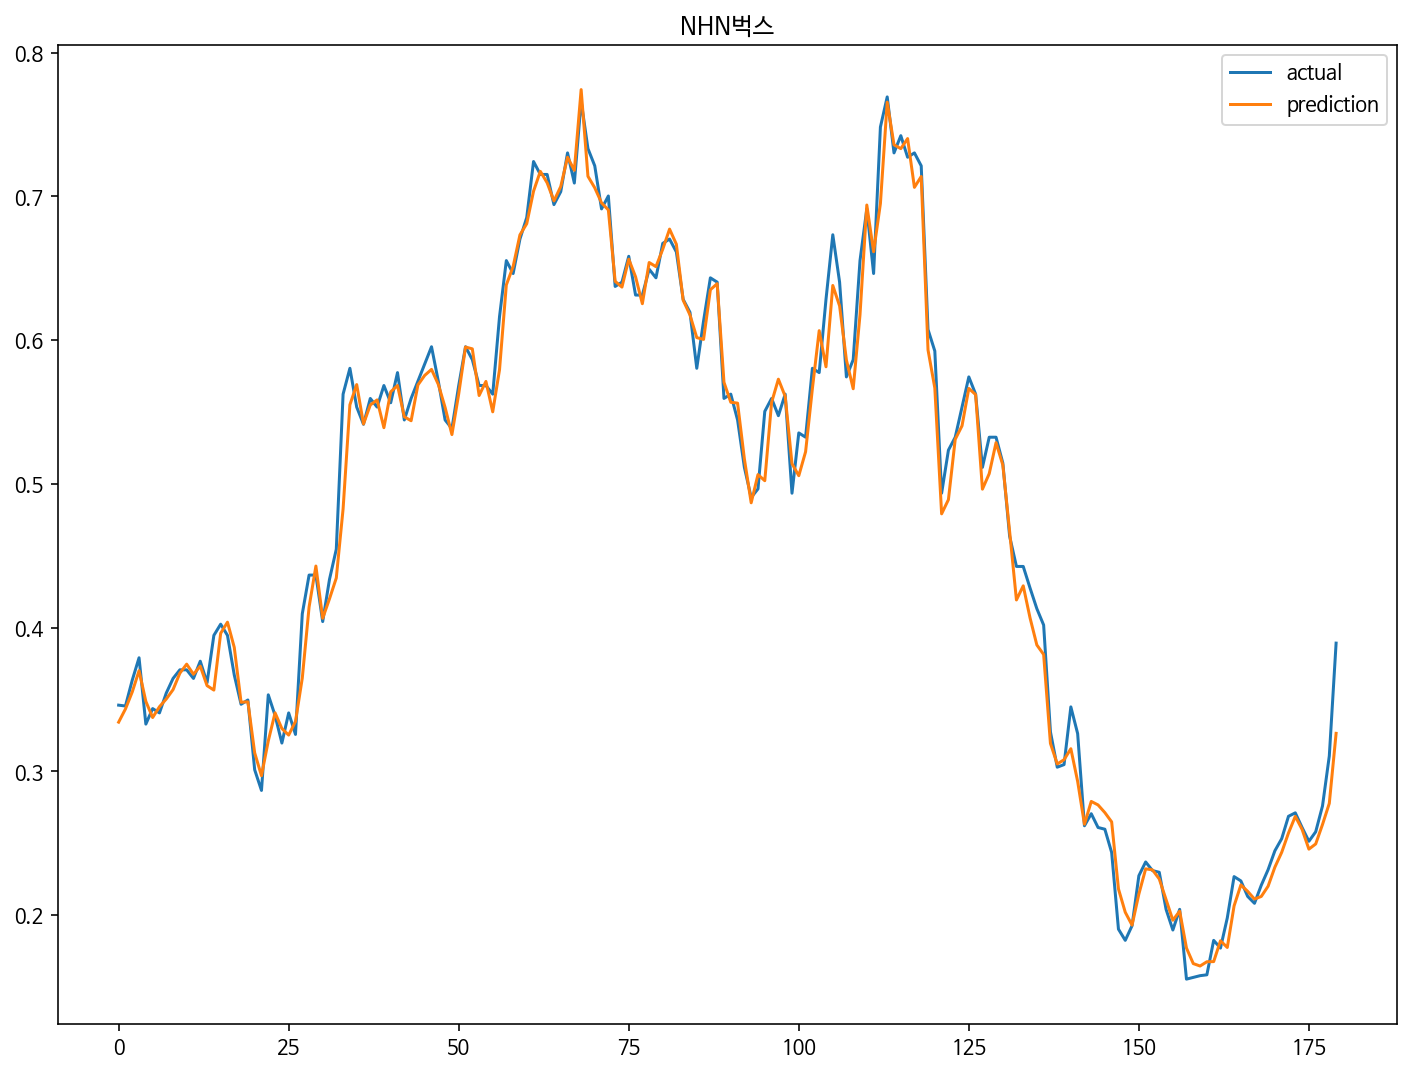

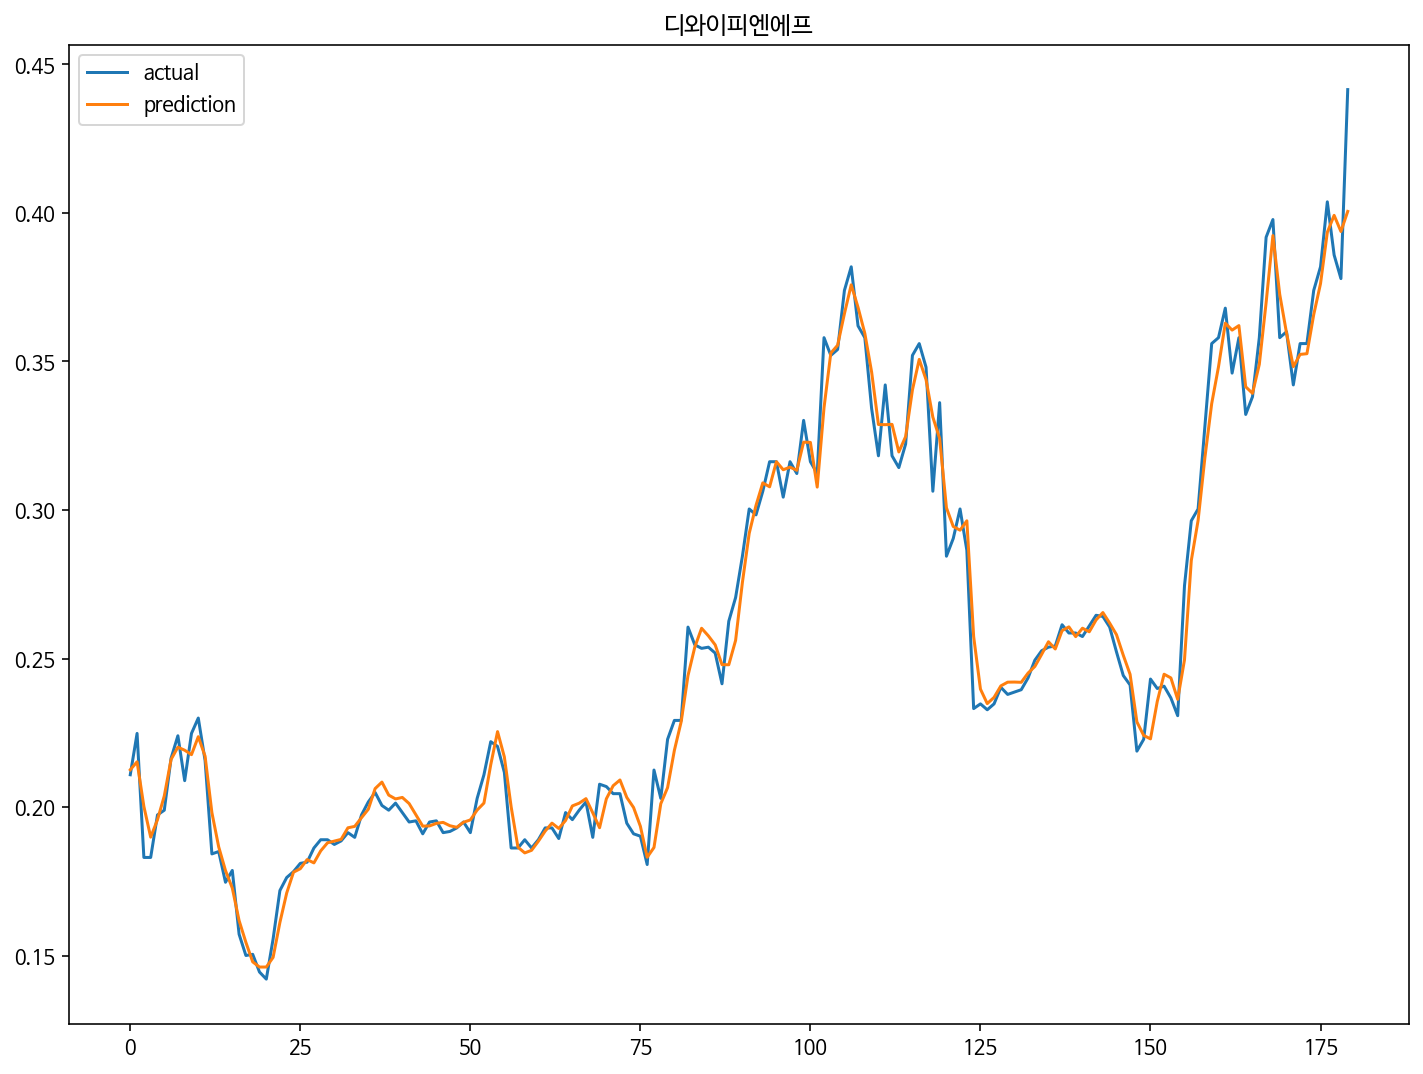

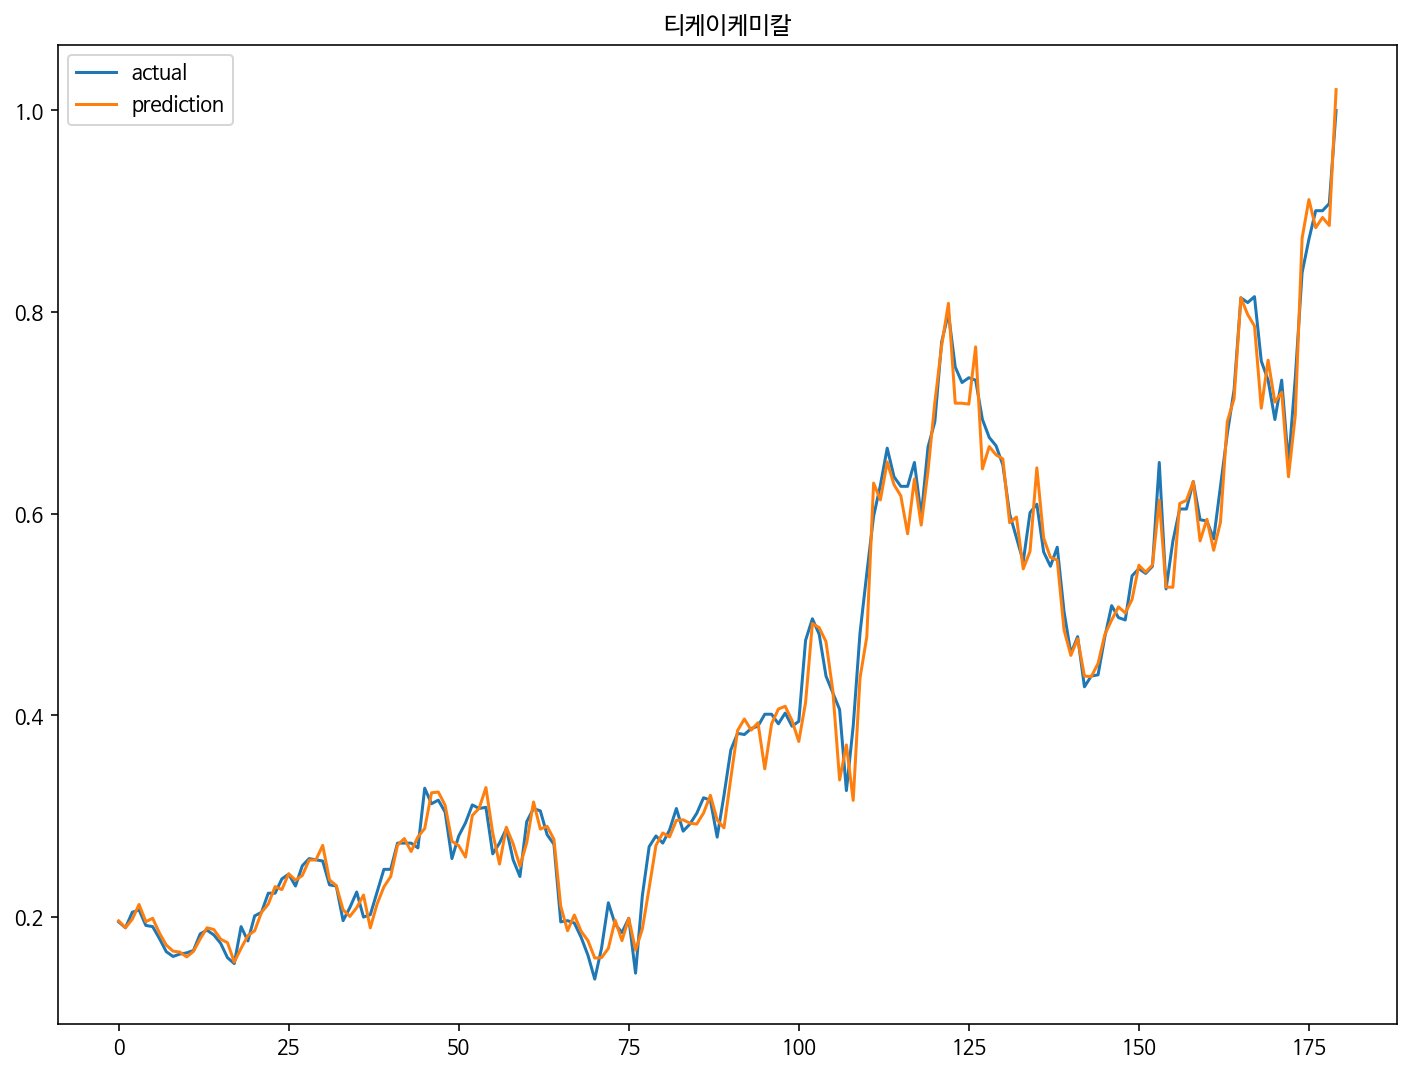

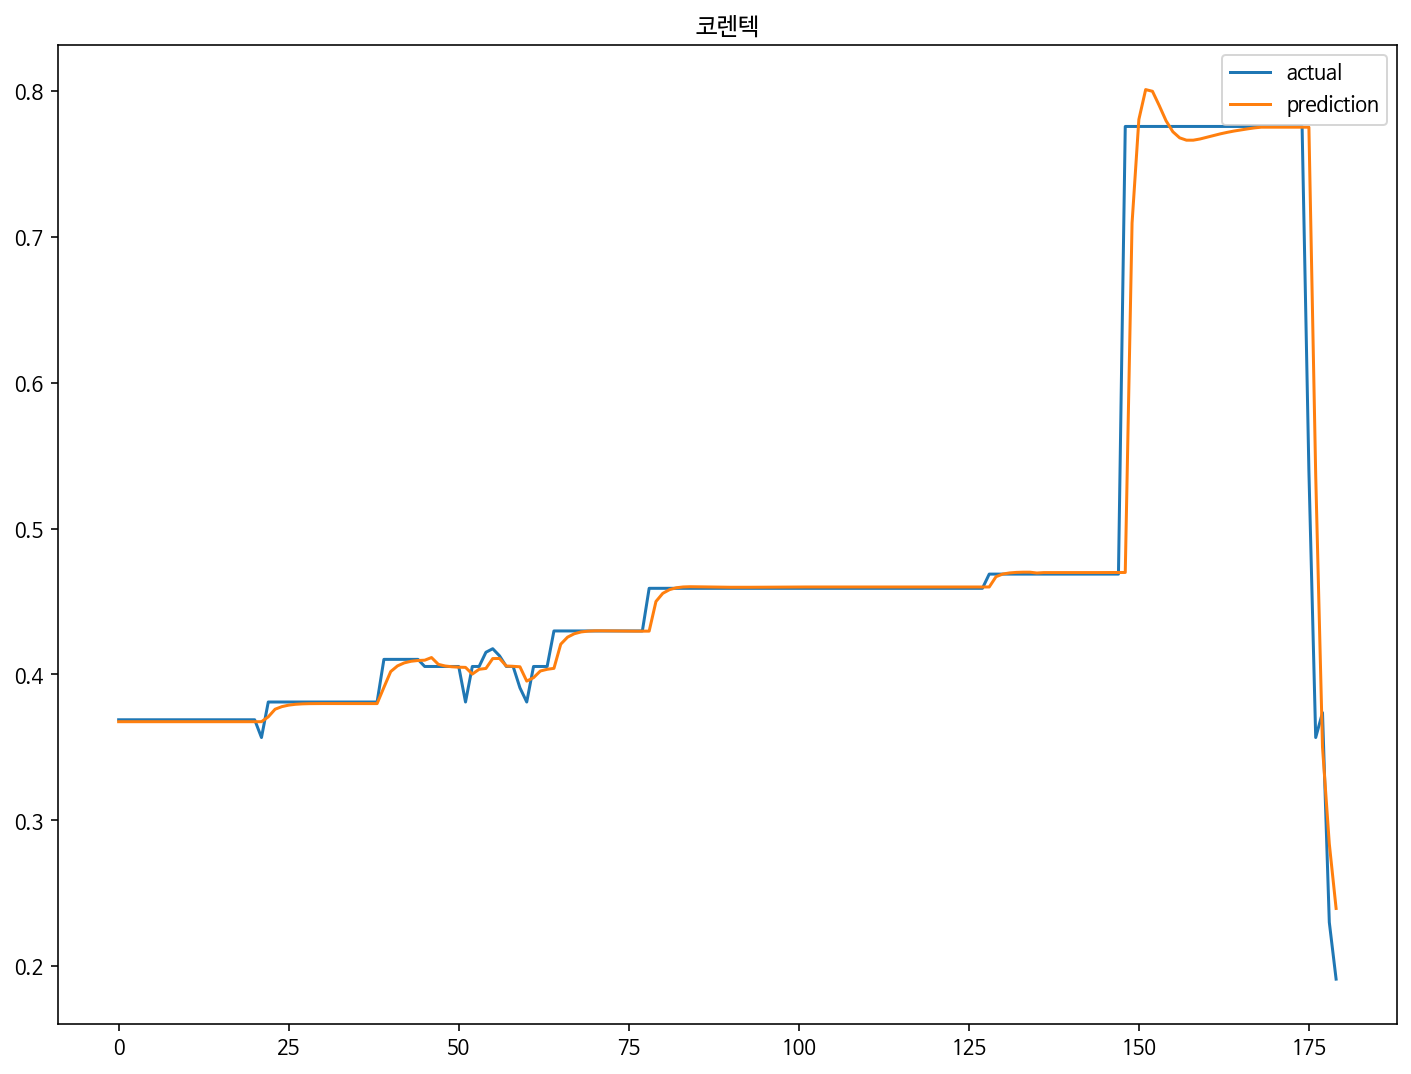

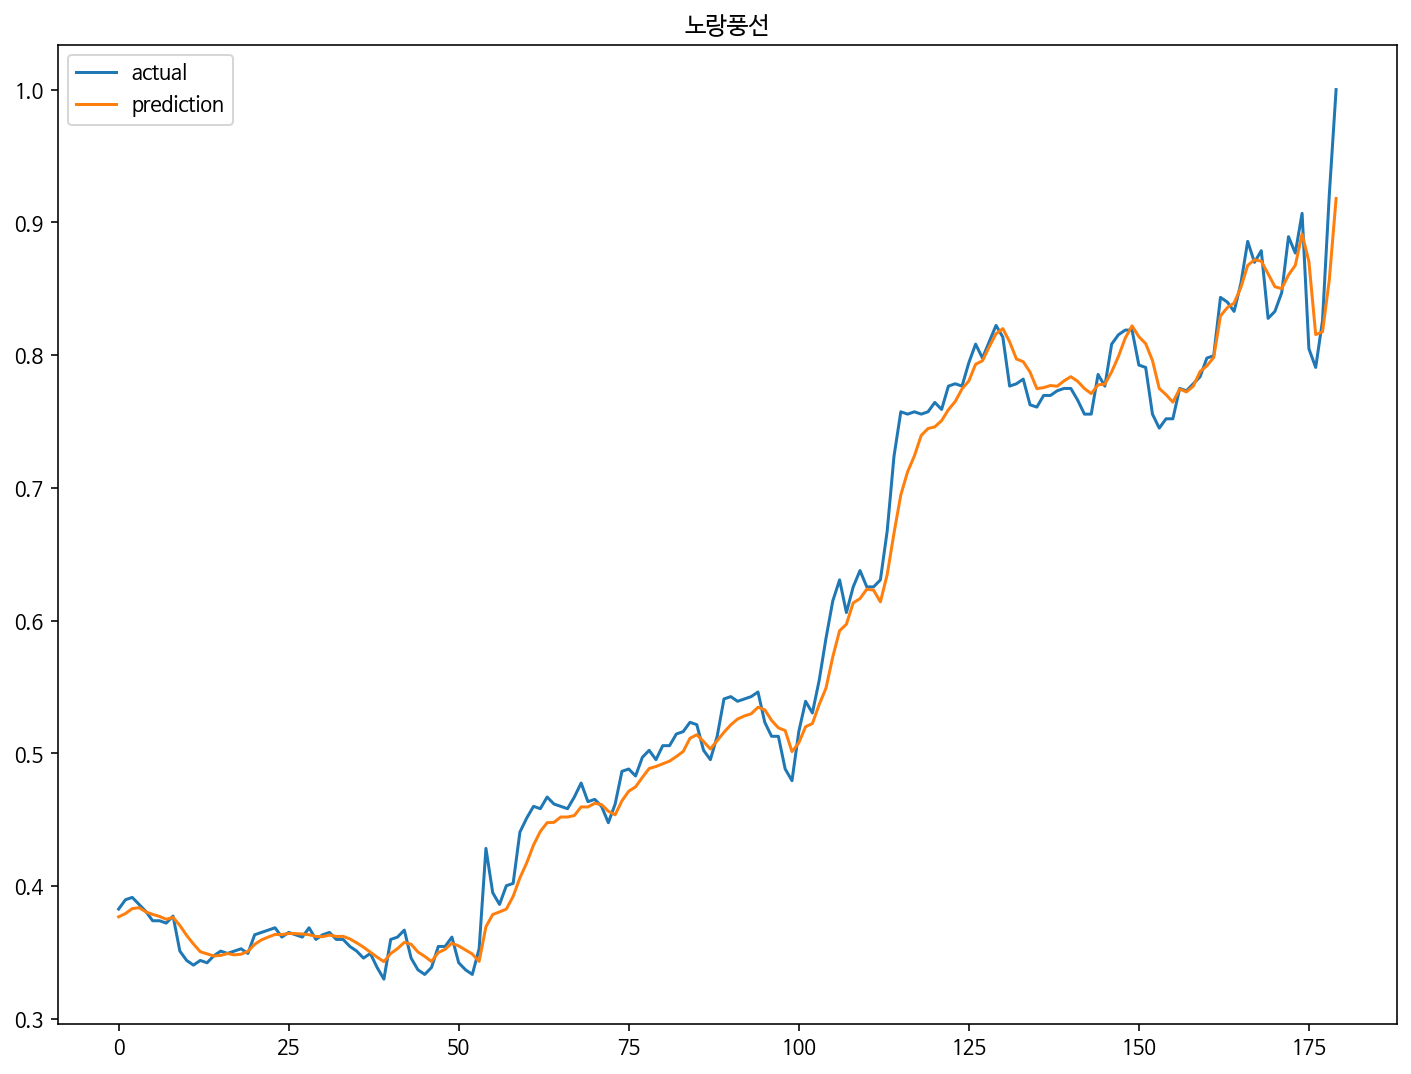

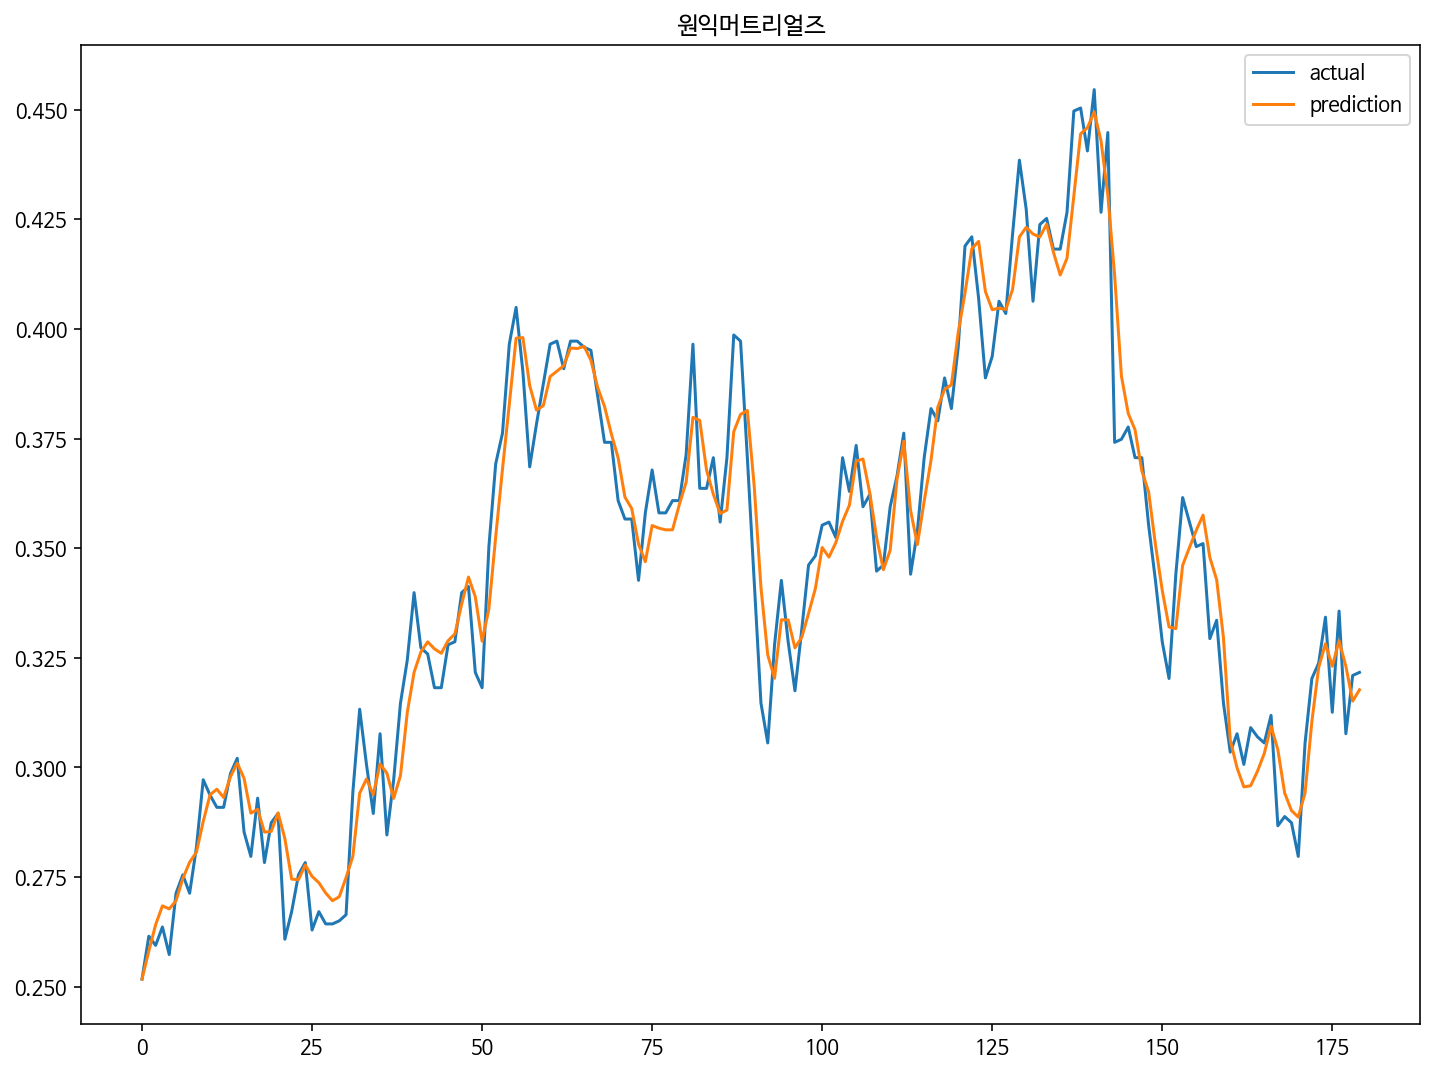

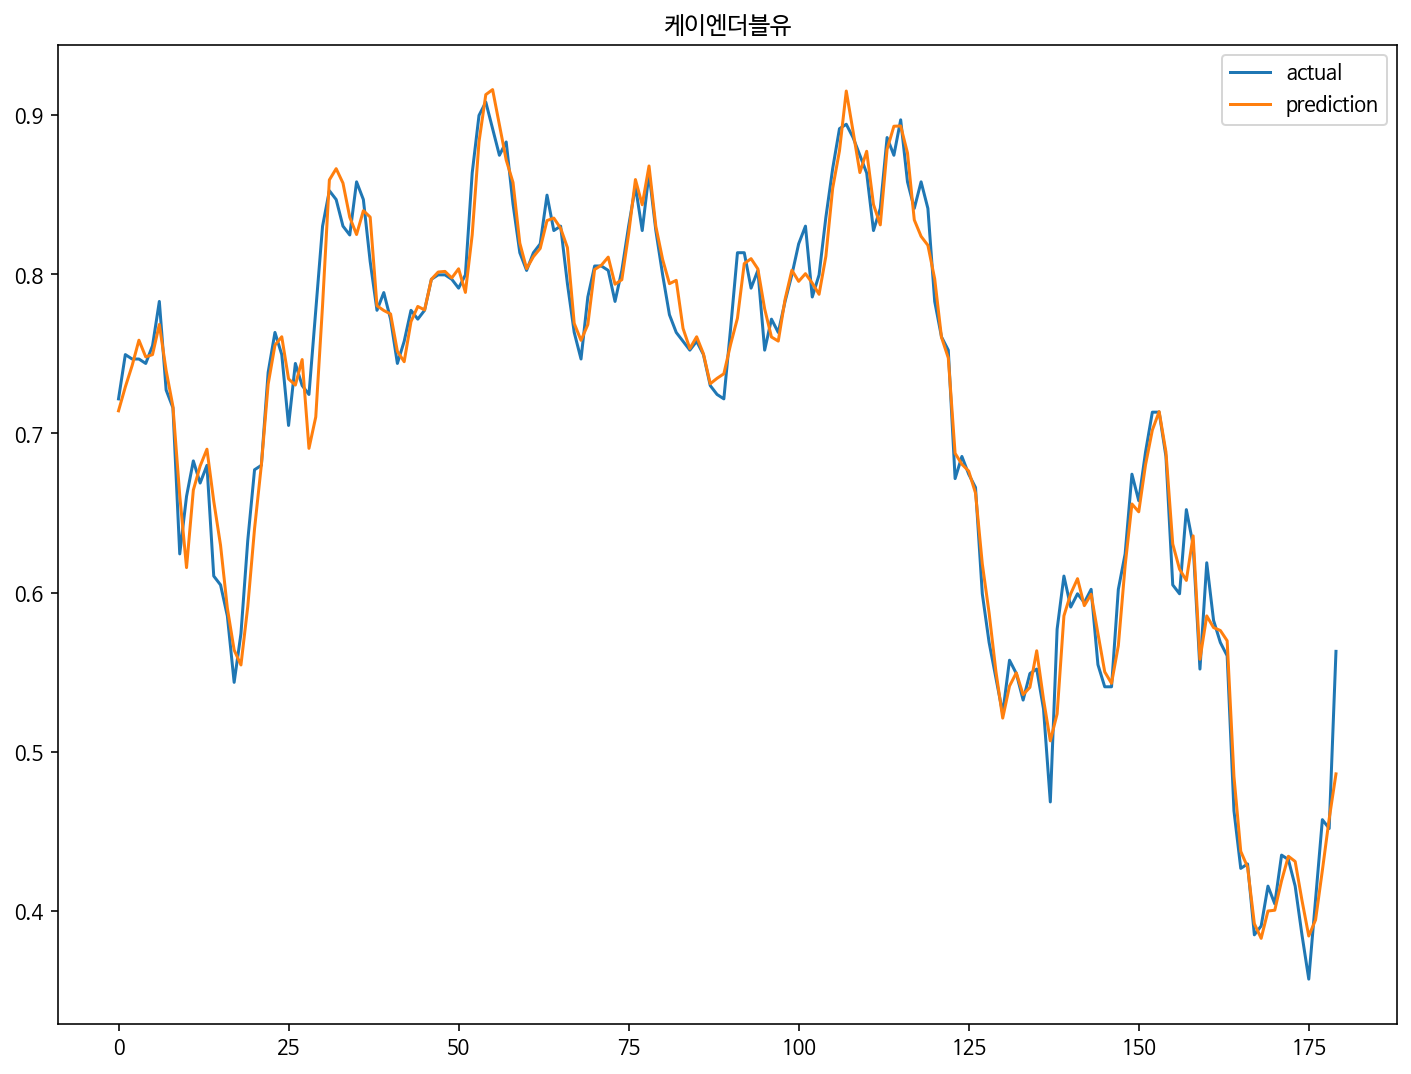

In [ ]:
image_collector(datalists)